# Leveraging Convolutional Autoencoder for Image Retrieval

In this notebook, we'll build a convolutional autoencoder to compress the MNIST dataset. Then, we'll use the compressed version to compare and retrieve similar images.

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for comparing images!

### Methodology
To build an image retrieval system with an autoencoder, what we really care about is that compressed representation vector.  Once an autoencoder has been trained to encode images, we can:
1.  Use the encoder portion of the network to compute the compressed representation of each image in  our  dataset  —this  representation  serves  as  our  feature  vector  that  quantifies  the contents of an image
2.  Compare the feature vector from our query image to all feature vectors in our dataset (typically we would use either the Euclidean or cosine distance)

Feature vectors that have a smaller distance will be considered more similar, while images with a larger distance will be deemed less similar.
<img src='notebook_ims/2.png' width=60%/>

Let's get started by importing our libraries and getting the dataset.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [4]:
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Visualize the Data

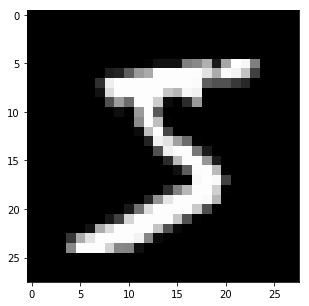

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

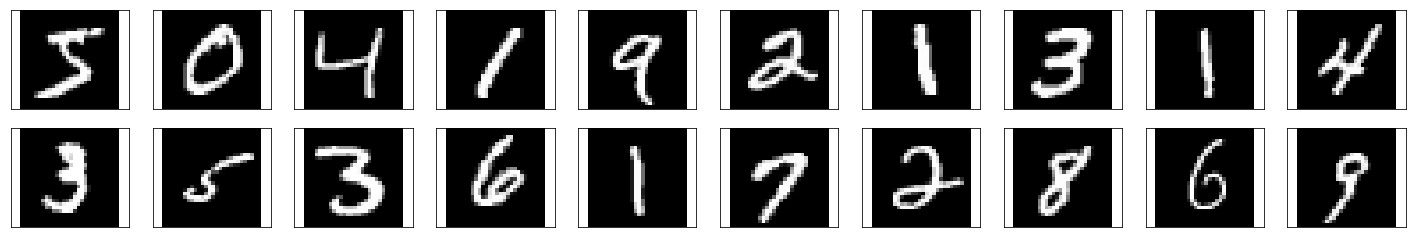

In [6]:
# plot multiple input images in each row
fig, axs = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for i in range(2):
    for j in range(10):
        axs[i, j].imshow(np.squeeze(images[i * 10 + j]), cmap='gray')
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)

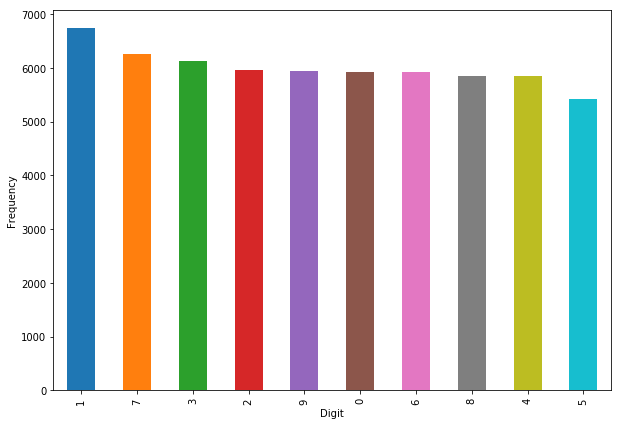

In [7]:
import pandas as pd
plt.figure(figsize = (10,7))
pd.value_counts(np.array(train_data.train_labels)).plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Digit')
plt.show()

In [8]:
pd.value_counts(np.array(train_data.train_labels))

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

## Linear Autoencoder
We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of one linear layer. The units that connect the encoder and decoder will be the compressed representation.

Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

<img src='notebook_ims/5.png' width=50% />

In [31]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the simple Autoencoder
encoding_dim = 32
simple_model = Autoencoder(encoding_dim)
print(simple_model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```


In [36]:
def train_model(model, optimizer, criterion, device, n_epochs = 100, simple = False):
    model.to(device)
    for epoch in range(1, n_epochs+1):
    # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            if(simple):
                images = images.view(images.size(0), -1)
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [38]:
# specify loss function
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01)

In [40]:
# number of epochs to train the model
n_epochs = 100

train_model(simple_model, optimizer, criterion, device, n_epochs, True)

Epoch: 1 	Training Loss: 0.573216
Epoch: 2 	Training Loss: 0.508323
Epoch: 3 	Training Loss: 0.502339
Epoch: 4 	Training Loss: 0.500032
Epoch: 5 	Training Loss: 0.498958
Epoch: 6 	Training Loss: 0.498238
Epoch: 7 	Training Loss: 0.497069
Epoch: 8 	Training Loss: 0.496974
Epoch: 9 	Training Loss: 0.497259
Epoch: 10 	Training Loss: 0.496965
Epoch: 11 	Training Loss: 0.496660
Epoch: 12 	Training Loss: 0.496923
Epoch: 13 	Training Loss: 0.496968
Epoch: 14 	Training Loss: 0.496827
Epoch: 15 	Training Loss: 0.496758
Epoch: 16 	Training Loss: 0.496805
Epoch: 17 	Training Loss: 0.497313
Epoch: 18 	Training Loss: 0.496941
Epoch: 19 	Training Loss: 0.496897
Epoch: 20 	Training Loss: 0.497073
Epoch: 21 	Training Loss: 0.497132
Epoch: 22 	Training Loss: 0.497100
Epoch: 23 	Training Loss: 0.497314
Epoch: 24 	Training Loss: 0.497494
Epoch: 25 	Training Loss: 0.497430
Epoch: 26 	Training Loss: 0.497826
Epoch: 27 	Training Loss: 0.497734
Epoch: 28 	Training Loss: 0.497752
Epoch: 29 	Training Loss: 0.4

In [41]:
PATH_SIMPLE = 'autoencoder_simple.pt'
torch.save(simple_model.state_dict(), PATH_SIMPLE)

In [ ]:
simple_model.load_state_dict(torch.load(PATH_SIMPLE))

In [42]:
simple_encoder = nn.Sequential(*list(simple_model.children())[:1])
print(simple_encoder)

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
)


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

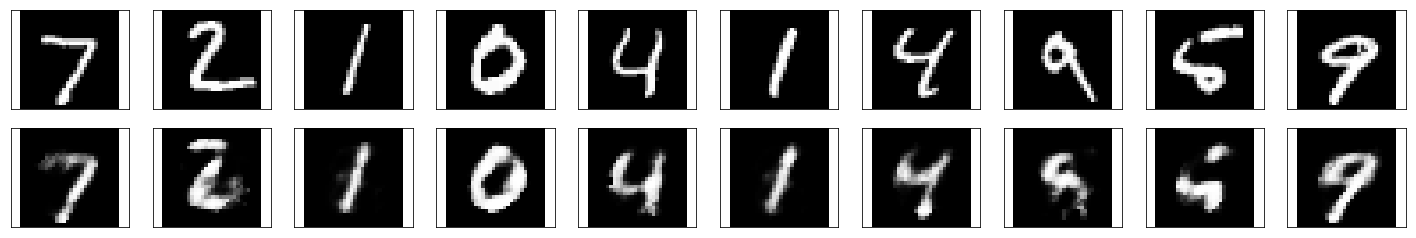

In [150]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.view(images.size(0), -1)

# get sample outputs
output = simple_model(images.to(device))

images = images.numpy()
# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img.reshape(28,28)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

---
## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

<img src='notebook_ims/conv_enc_1.png' width=640px>

Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 

#### Build the network shown above. 
> Build the encoder out of a series of convolutional and pooling layers. 
> When building the decoder, recall that transpose convolutional layers can upsample an input by a factor of 2 using a stride and kernel_size of 2. 

In [43]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1,16,3,padding = 1)
        self.conv2 = nn.Conv2d(16,4,3,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        ## decode ##
        ## apply ReLu to all hidden layers *except for the output layer
        ## apply a sigmoid to the output layer
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the convolutional Autoencoder
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. Since this is a convlutional autoencoder, our images _do not_ need to be flattened before being passed in an input to our model.

In [6]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
# number of epochs to train the model
n_epochs = 100

train_model(model, optimizer, criterion, device, n_epochs)

Epoch: 1 	Training Loss: 0.543804
Epoch: 2 	Training Loss: 0.411110
Epoch: 3 	Training Loss: 0.396724
Epoch: 4 	Training Loss: 0.390211
Epoch: 5 	Training Loss: 0.385606
Epoch: 6 	Training Loss: 0.381367
Epoch: 7 	Training Loss: 0.378488
Epoch: 8 	Training Loss: 0.375957
Epoch: 9 	Training Loss: 0.374209
Epoch: 10 	Training Loss: 0.372285
Epoch: 11 	Training Loss: 0.370712
Epoch: 12 	Training Loss: 0.369930
Epoch: 13 	Training Loss: 0.369305
Epoch: 14 	Training Loss: 0.368185
Epoch: 15 	Training Loss: 0.367371
Epoch: 16 	Training Loss: 0.366358
Epoch: 17 	Training Loss: 0.365304
Epoch: 18 	Training Loss: 0.364718
Epoch: 19 	Training Loss: 0.363870
Epoch: 20 	Training Loss: 0.362867
Epoch: 21 	Training Loss: 0.361967
Epoch: 22 	Training Loss: 0.360690
Epoch: 23 	Training Loss: 0.360080
Epoch: 24 	Training Loss: 0.358832
Epoch: 25 	Training Loss: 0.356750
Epoch: 26 	Training Loss: 0.355412
Epoch: 27 	Training Loss: 0.354191
Epoch: 28 	Training Loss: 0.353583
Epoch: 29 	Training Loss: 0.3

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

(20, 1, 28, 28)


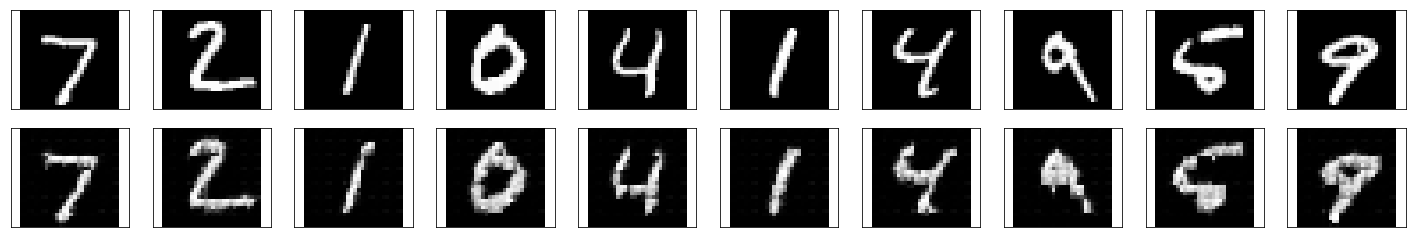

In [145]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device))
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [44]:
PATH = 'auto_encoder.pt'

In [ ]:
torch.save(model.state_dict(), PATH)

In [143]:
model.load_state_dict(torch.load(PATH))
model.cuda()

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [49]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        ## encoder layers ##
        self.layer1 = nn.Sequential(*list(model.children())[:3])
        self.pool = [*list(model.children())][2]

    def forward(self, x):
        ## encode ##
        x = self.layer1(x)
        x = self.pool(x)
        
        return x

# initialize the Encoder
encoder = ConvEncoder()
encoder.to(device)

ConvEncoder(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# Evaluate the models

Model evaluate steps are as follows:  

1- calculate the features of all the trained images.  
2- calculate the features of the test set and retrieve 7 similar images to each image in the test set.  
3- calculate the accuracy of the model.  

In [77]:
def compute_accuracy(query_imgs_ids, similar_imgs_ids):
    """ return the accuracy of the retrieval process.
    Args:
        query_imgs_ids: a list of ids to the query images.
        similar_imgs_ids: a list of lists of similar images id to each query image.
        
    """
    total_imgs = len(similar_imgs_ids[0]) * len(query_imgs_ids)
    correctly_retrieved_counter = 0
    
    for i, query_img_id in enumerate(query_imgs_ids):
        query_img, query_label = test_data[int(query_img_id)]
        for image in similar_imgs_ids[i]:
            img, label = train_data[int(image)]
            if label == query_label:
                correctly_retrieved_counter += 1
    return correctly_retrieved_counter/total_imgs

In [177]:
def show_retrieved_images(similar_indexes, n = 10):
    # get similar images from indexes
    similar_images = np.array([], dtype='float32').reshape(0, 7, 1, 28, 28) 

    for i, images in enumerate(similar_indexes):
        temp = np.array([], dtype='float32').reshape(0, 1, 28, 28) 
        for image in images:
            img, _ = train_data[int(image)]
            temp = np.concatenate((temp, img.reshape(1, 1, 28, 28)))
        similar_images = np.concatenate((similar_images, temp.reshape(1, 7, 1, 28, 28)))
    
    # plot    
    print('The query image to the left is followed by 7 similar images retrieved from the training data set')
    # plot the first ten input images and then reconstructed images
    nrows = n
    fig, axes = plt.subplots(nrows=nrows, ncols=8, sharex=True, sharey=True, figsize=(25,25))

    for i, b in enumerate(range(similar_images.shape[0])):
        if i == nrows:
            break
        t_img, _ = test_data[i]
        axes[i, 0].imshow(np.squeeze(t_img), cmap='gray')
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        for j in range(similar_images.shape[1]):
            axes[i, j+1].imshow(np.squeeze(similar_images[i][j]), cmap='gray')
            axes[i, j+1].get_xaxis().set_visible(False)
            axes[i, j+1].get_yaxis().set_visible(False)

In [48]:
# Function to retrieve the closest images
def retrieve_closest_images(test_feature, trained_features, n=7):

    # initialize the distance list
    distances = []

    for features in trained_features:
        distance = np.linalg.norm(features - test_feature)
        distances.append(distance) # append to the distance list

    n_elements = trained_features.shape[0] # total number of images in the training set
    distances = np.array(distances) # convert the distance list to a numpy array
    trained_features_index = np.arange(n_elements) # creae an index list from 0 - n_elements

    # create a numpy stack with the distances, index_list
    distances_with_index = np.stack((distances, trained_features_index), axis=-1)
    sorted_distance_with_index = distances_with_index[distances_with_index[:,0].argsort()] # sort the stack

    sorted_distances = sorted_distance_with_index[:, 0].astype('float32') # change the datatype
    sorted_indexes = sorted_distance_with_index[:, 1]

    kept_indexes = sorted_indexes[:n] # Get the first n indexes of the sorted_indexes list

    return kept_indexes.astype('int')

In [116]:
# get all similar images to the first 100 test set given a model
def get_similar_indexes(model, trained_features, simple = False):
    similar_indexes = []
    for i, data in enumerate(test_data):
        if i == 100:
            break
        test_image, _ = data
        test_image = test_image.to(device)
        test_image = test_image.view(1,1,28,28)
        if(simple):
            test_image = images.view(images.size(0), -1)

        # predict the encoder layer codes for the test image
        test_feature = model.forward(test_image).cpu().detach().numpy()

        # get top 7 similar images
        similar_indexes.append(retrieve_closest_images(test_feature, trained_features))
    return similar_indexes

### Simple Autoencoder evaluation

In [101]:
# initialize the training features
trained_simple_features = np.array([], dtype='float32').reshape(0, 20, 32) 

# predict the encoder layer features for the training dataset
for data in train_loader:
    images, _ = data
    images = images.to(device)
    images = images.view(images.size(0), -1)
    predicted_features = simple_encoder.forward(images).cpu().detach().numpy()
    predicted_features = predicted_features.reshape(1, 20, 32)
    trained_simple_features = np.concatenate((trained_simple_features, predicted_features))

In [127]:
# get similar indices
simple_similar_indexes = get_similar_indexes(simple_encoder, trained_simple_features, True)

In [128]:
# calculate accuracy for the first 100 test images
print('The accuracy of the simple autoencoder:', compute_accuracy(range(100), simple_similar_indexes))

The accuracy of the simple autoencoder: 0.10428571428571429


The query image to the left is followed by 7 similar images retrieved from the training data set


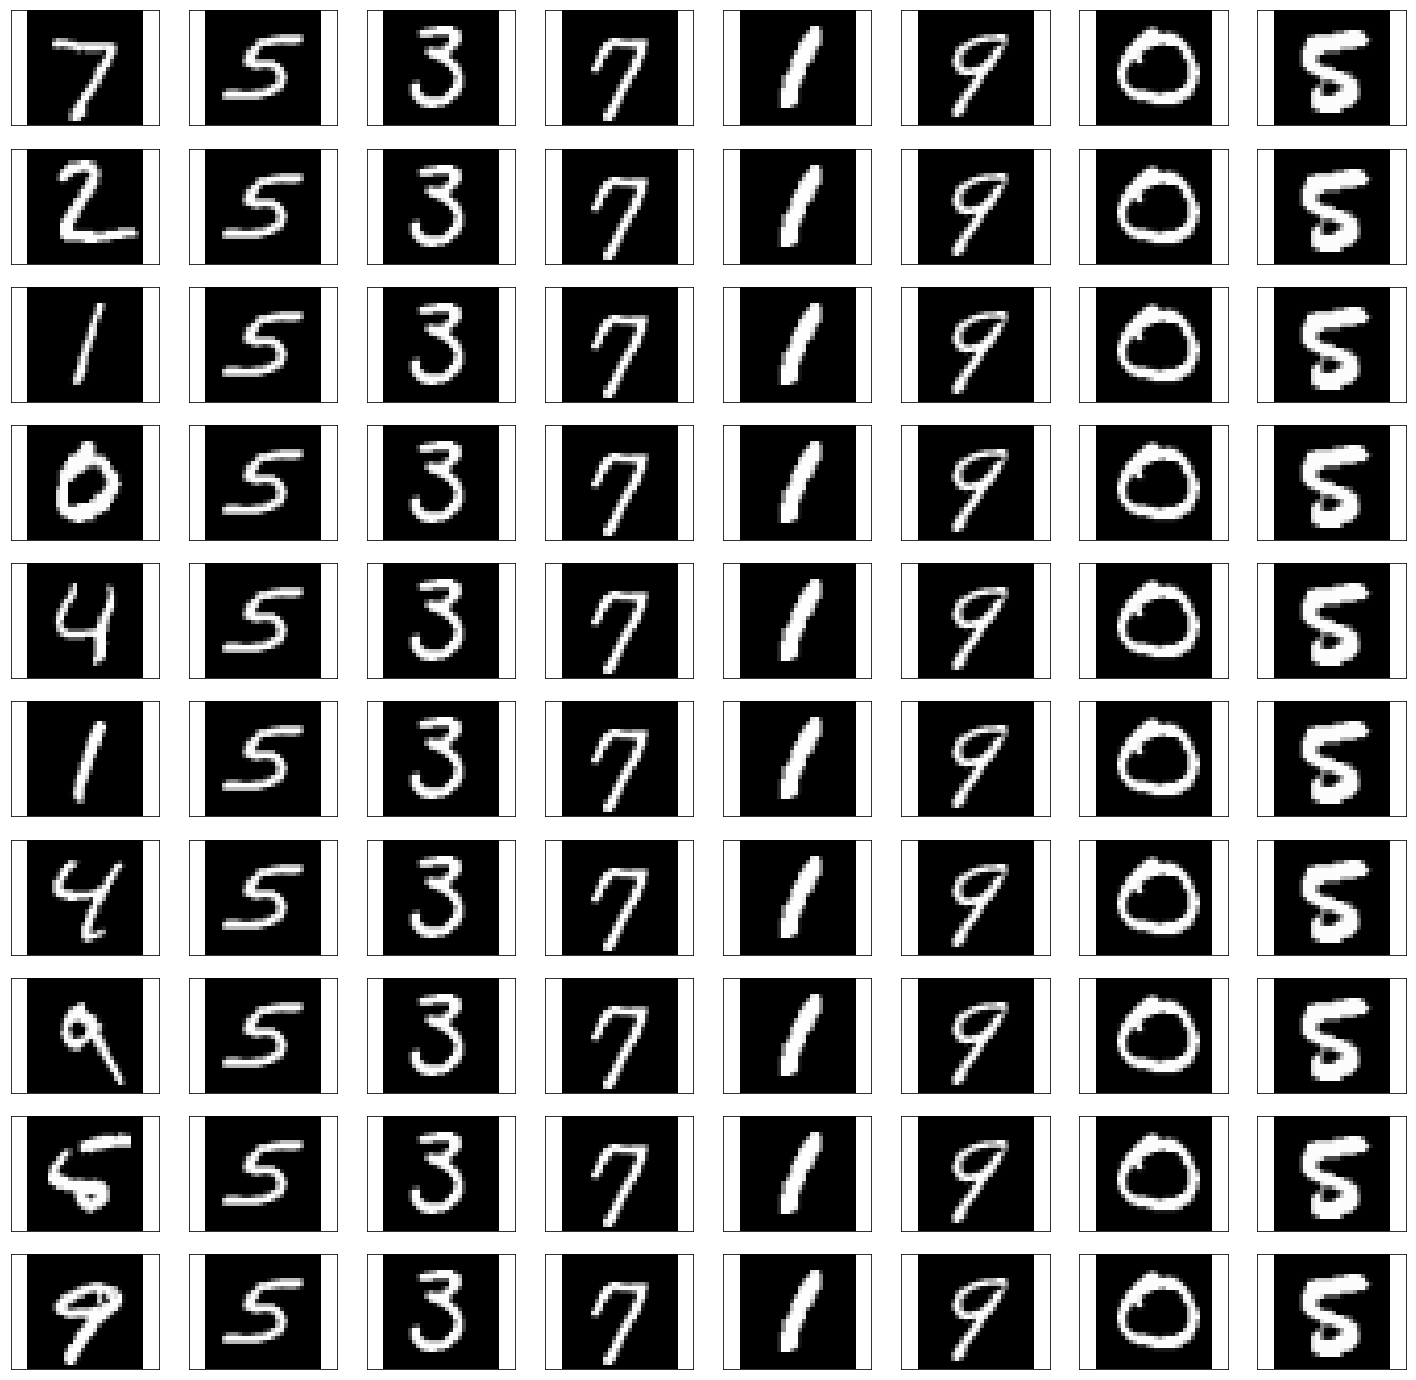

In [129]:
show_retrieved_images(simple_similar_indexes)

### Convolutional Autoencoder evaluation

In [52]:
# initialize the training features
trained_features = np.array([], dtype='float32').reshape(0, 4, 7, 7) 

In [53]:
# predict the encoder layer features for the training dataset
for data in train_loader:
    images, _ = data
    images = images.to(device)
    predicted_features = encoder.forward(images).cpu().detach().numpy()
    trained_features = np.concatenate((trained_features, predicted_features))

In [123]:
# get similar indices
similar_indexes = get_similar_indexes(encoder, trained_features)

In [124]:
# calculate accuracy for the first 100 test images
print('The accuracy of the convolutional autoencoder:', compute_accuracy(range(100), similar_indexes))

The accuracy of the convolutional autoencoder: 0.9057142857142857


The query image to the left is followed by 7 similar images retrieved from the training data set


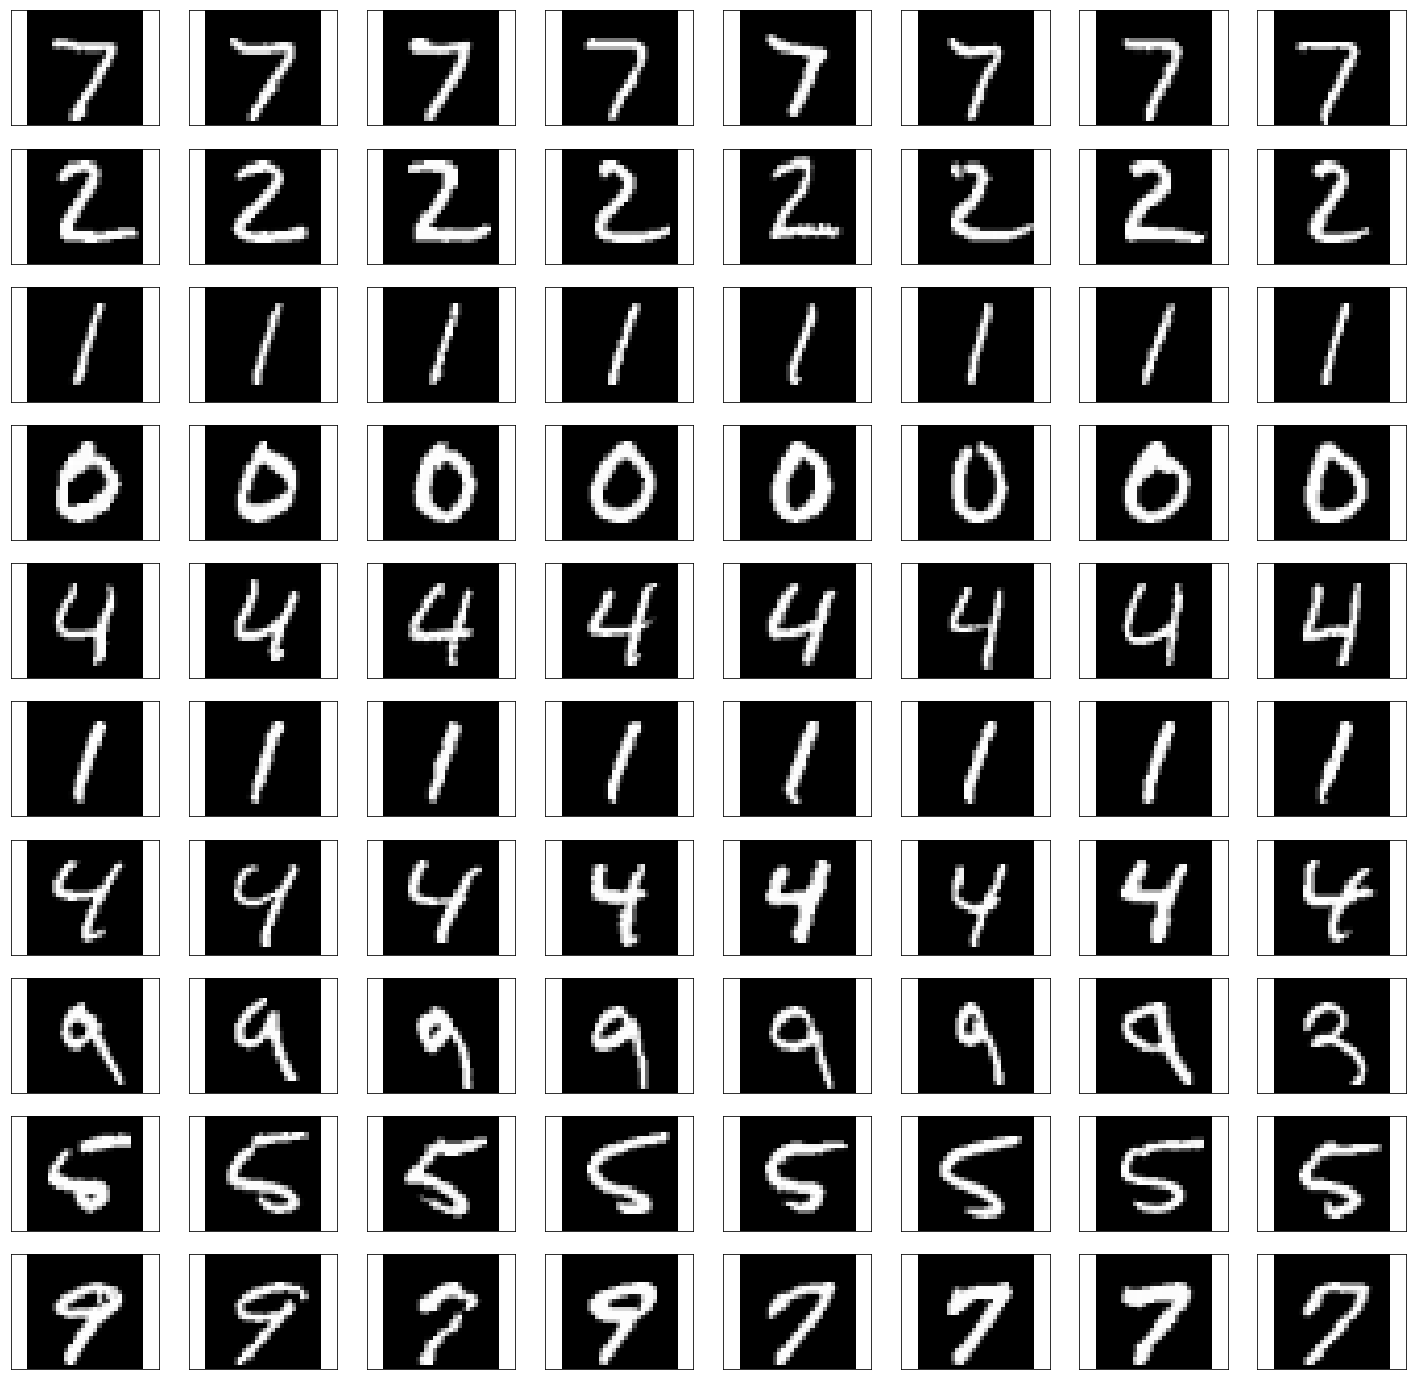

In [130]:
show_retrieved_images(similar_indexes)

### Refinement
we'll try to improve the model by adding bath normalization layer in the convolutional autoencoder.

In [167]:
# define the NN architecture
class ConvAutoencoder2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1,16,3,padding = 1)
        self.conv2 = nn.Conv2d(16,4,3,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch = nn.BatchNorm2d(16)
        self.batch2 = nn.BatchNorm2d(4)
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        x = F.relu(self.batch(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.batch2(self.conv2(x)))
        x = self.pool(x)
        ## decode ##
        ## apply ReLu to all hidden layers *except for the output layer
        ## apply a sigmoid to the output layer
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the convolutional Autoencoder
model_refined = ConvAutoencoder2()
print(model_refined)

ConvAutoencoder2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [168]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model_refined.parameters(), lr=0.01)

In [169]:
# number of epochs to train the model
n_epochs = 100

train_model(model_refined, optimizer, criterion, device, n_epochs)

Epoch: 1 	Training Loss: 0.292964
Epoch: 2 	Training Loss: 0.185015
Epoch: 3 	Training Loss: 0.175036
Epoch: 4 	Training Loss: 0.171672
Epoch: 5 	Training Loss: 0.170543
Epoch: 6 	Training Loss: 0.169718
Epoch: 7 	Training Loss: 0.168705
Epoch: 8 	Training Loss: 0.167839
Epoch: 9 	Training Loss: 0.167315
Epoch: 10 	Training Loss: 0.166856
Epoch: 11 	Training Loss: 0.166338
Epoch: 12 	Training Loss: 0.165595
Epoch: 13 	Training Loss: 0.164909
Epoch: 14 	Training Loss: 0.164376
Epoch: 15 	Training Loss: 0.163961
Epoch: 16 	Training Loss: 0.163685
Epoch: 17 	Training Loss: 0.163454
Epoch: 18 	Training Loss: 0.163296
Epoch: 19 	Training Loss: 0.163184
Epoch: 20 	Training Loss: 0.163017
Epoch: 21 	Training Loss: 0.162864
Epoch: 22 	Training Loss: 0.162711
Epoch: 23 	Training Loss: 0.162555
Epoch: 24 	Training Loss: 0.162455
Epoch: 25 	Training Loss: 0.162362
Epoch: 26 	Training Loss: 0.162276
Epoch: 27 	Training Loss: 0.162216
Epoch: 28 	Training Loss: 0.162144
Epoch: 29 	Training Loss: 0.1

In [170]:
PATH2 = 'refined_autoencoder.pt'
torch.save(model_refined.state_dict(), PATH2)

In [171]:
class ConvEncoder2(nn.Module):
    def __init__(self):
        super(ConvEncoder2, self).__init__()
        ## encoder layers ##
        self.layer1 = nn.Sequential(*list(model_refined.children())[:3])
        self.pool = [*list(model_refined.children())][2]

    def forward(self, x):
        ## encode ##
        x = self.layer1(x)
        x = self.pool(x)
        
        return x

# initialize the Encoder
encoder_refined = ConvEncoder2()
encoder_refined.to(device)

ConvEncoder2(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [172]:
# initialize the training features
trained_features_refined = np.array([], dtype='float32').reshape(0, 4, 7, 7) 

# predict the encoder layer features for the training dataset
for data in train_loader:
    images, _ = data
    images = images.to(device)
    predicted_features = encoder_refined.forward(images).cpu().detach().numpy()
    trained_features_refined = np.concatenate((trained_features_refined, predicted_features))

In [173]:
# get similar indices
similar_indexes_refined = get_similar_indexes(encoder_refined, trained_features_refined)

In [174]:
# calculate accuracy for the first 100 test images
print('The accuracy of the refined convolutional autoencoder:', compute_accuracy(range(100), similar_indexes_refined))

The accuracy of the refined convolutional autoencoder: 0.93


The query image to the left is followed by 7 similar images retrieved from the training data set


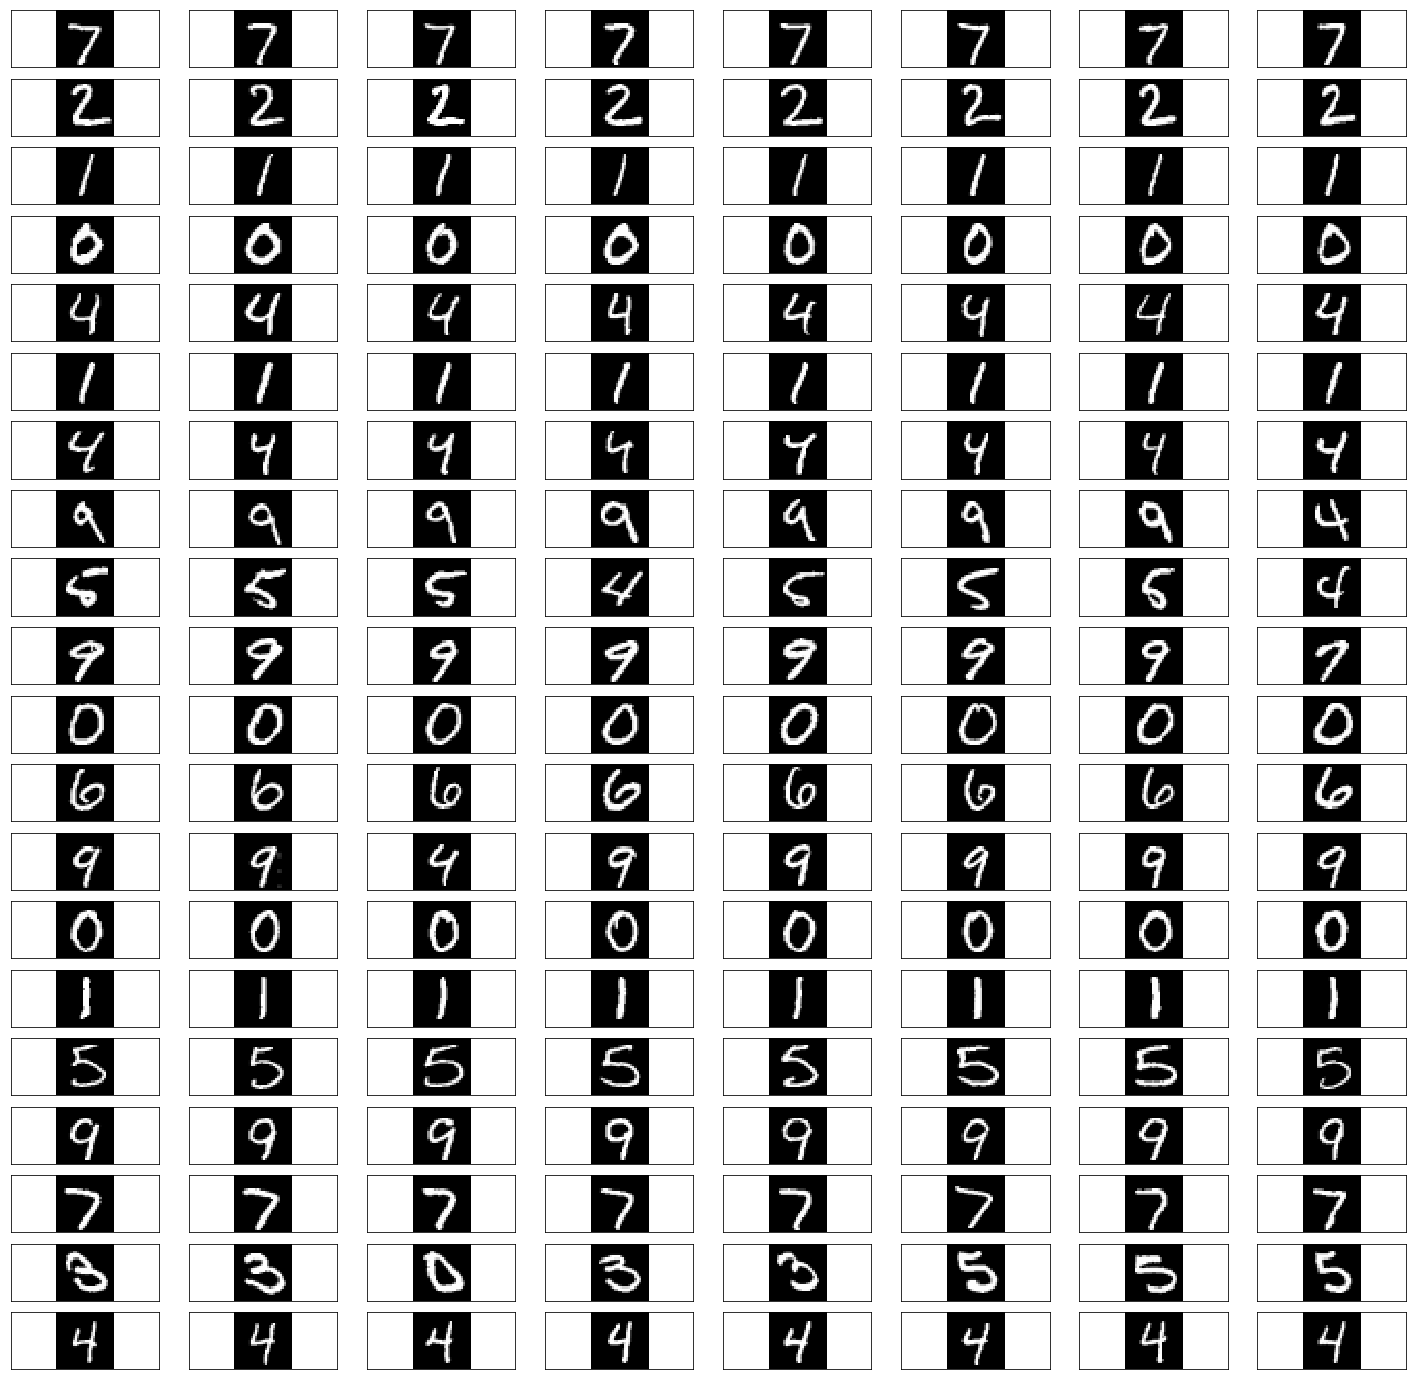

In [178]:
show_retrieved_images(similar_indexes_refined, n = 20)